**Importing required libraries**

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from spreg import ML_Lag, ML_Error
from libpysal.weights.util import get_points_array_from_shapefile
from libpysal.weights import Queen
import geopandas as gpd
from libpysal import weights
import matplotlib.pyplot as plt
import contextily as ctx
import libpysal as lps
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pysal.lib
import pysal.model.spreg
from pysal.model.spreg import GM_Error_Het
from pysal.lib import weights

**Importing the datasets**: 
Assigning the file paths of call detail records, remote sensing data, and principle component analysis data to mobile_path, satellite_path, and pca_path respectively

In [102]:
mobile_path = '/Users/chanukaalgama/Desktop/DAP PROJECTS/RS + CDR Poverty Mapping/poverty-mapping-liao-220902/data/mobile_features.csv'
satellite_path = '/Users/chanukaalgama/Desktop/DAP PROJECTS/RS + CDR Poverty Mapping/poverty-mapping-liao-220902/data/satellite_features.csv'
pca_path = '/Users/chanukaalgama/Desktop/DAP PROJECTS/RS + CDR Poverty Mapping/poverty-mapping-liao-220902/data/pca_census.csv'

# **Data Cleaning**

In [103]:
#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)
print('')

No of gnds with zero population: 37


In [104]:
# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc_1"}).set_index('gnd_id')

In [105]:
#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

# **Data Processing**

In [106]:
# Log transform skewed variables
data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])


#Optional step, consider rs_only variable when conducting the study only with remote sensing data
rs_only = data_unskewed[[
    "travel_time_major_cities_log",
    "population_count_worldpop_log",
    "population_count_ciesin_log",
    "population_density_log",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation_log",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk_log",
    "distance_roadways_primary_log",
    "distance_roadways_secondary_log",
    "distance_roadways_tertiary_log",
    "distance_waterways_log",
    "urban_rural_fb_log",
    "urban_rural_ciesin",
    "global_human_settlement_log",
    "protected_areas_log",
    "land_cover_woodland",
    "land_cover_grassland_log",
    "land_cover_cropland",
    "land_cover_wetland_log",
    "land_cover_bareland_log",
    "land_cover_urban",
    "land_cover_water_log",
    "pregnancies_log",
    "births_log",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

#Optional step, consider cdr_only variable when conducting the study only with call detail records

cdr_only = data_unskewed[[
"call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",
    #principle componanet analysis
    "pc_1" 
]].copy()

#data_unskewed = cdr_only.copy()


In [107]:
data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

In [108]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

call_count                         0
avg_call_duration                  0
nighttime_call_count               0
avg_nighttime_call_duration        0
incoming_call_count                0
avg_incoming_call_duration         0
unique_tower_count                 0
spatial_entropy                    0
avg_call_count_per_contact         0
avg_call_duration_per_contact      0
contact_count                      0
social_entropy                     0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
vegetation                         0
distance_roadways_motorway         0
urban_rural_ciesin                 0
land_cover_woodland                0
land_cover_cropland                0
land_cover_urban                   0
precipitation                      0
temperature                        0
pc_1                               0
radius_of_gyration_log             0
travel_time_major_cities_log       0
population_count_worldpop_log      0
p

**Data stratification based on Province**

**Loading the Sri Lanka shapefile**

In [109]:
data_shapefile = gpd.read_file("sri_lanka_gnd/sri_lanka_gnd.shp")
#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)
data_shapefile = data_shapefile.to_crs(epsg=3857)

**Merge the shape file with the dataframe**

In [110]:
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')

In [111]:
merged.head(100)

,code_7,call_count,avg_call_duration,nighttime_call_count,avg_nighttime_call_duration,incoming_call_count,avg_incoming_call_duration,unique_tower_count,spatial_entropy,avg_call_count_per_contact,...,land_cover_wetland_log,land_cover_bareland_log,land_cover_water_log,pregnancies_log,births_log,prov_name,dist_name,dsd_name,gnd_name,geometry
0,1103005,2983.347272,109.736455,258.273202,158.339897,1394.390617,108.199741,67.281489,0.386727,13.067985,...,0.0,0.0,0.00000,3.793410,3.407934,Western,Colombo,Colombo,Sammanthranapura,"POLYGON ((8891903.546 778340.051, 8891876.960 ..."
1,1103010,3115.096453,113.275011,256.420453,165.039452,1454.389404,111.778611,68.324745,0.386224,13.588289,...,0.0,0.0,0.09531,7.302625,6.917149,Western,Colombo,Colombo,Mattakkuliya,"POLYGON ((8891588.324 778696.317, 8891623.033 ..."
2,1103015,3271.991912,113.882146,272.819563,167.605376,1535.191949,112.623913,68.665852,0.371180,14.316651,...,0.0,0.0,0.00000,6.363817,5.978341,Western,Colombo,Colombo,Modara,"POLYGON ((8890828.772 777806.715, 8890829.232 ..."
3,1103020,2986.160123,112.830805,254.428356,163.728059,1400.083580,111.454820,65.247871,0.391208,13.878327,...,0.0,0.0,0.00000,5.310735,4.925259,Western,Colombo,Colombo,Madampitiya,"POLYGON ((8891529.735 776549.660, 8891511.091 ..."
4,1103025,2742.650735,109.498520,255.465969,156.282917,1284.386005,106.600350,61.698145,0.391679,13.397243,...,0.0,0.0,0.00000,5.988538,5.603062,Western,Colombo,Colombo,Mahawatta,"POLYGON ((8891136.015 776838.685, 8891221.430 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1109075,2776.345015,124.320865,179.753179,184.370422,1289.378679,124.802996,89.635261,0.440404,13.441146,...,0.0,0.0,0.00000,4.153400,3.767924,Western,Colombo,Kaduwela,Thunadahena,"POLYGON ((8903267.345 768991.677, 8903264.881 ..."
96,1109080,2685.144329,115.607002,173.174237,168.105681,1261.719644,117.218322,86.010815,0.415802,13.732192,...,0.0,0.0,0.00000,4.689868,4.304392,Western,Colombo,Kaduwela,Korathota,"POLYGON ((8906587.231 771944.676, 8906580.687 ..."
97,1109085,2600.515375,115.577524,171.142681,164.106032,1216.159217,116.434293,82.523490,0.402692,13.579191,...,0.0,0.0,0.00000,4.213743,3.828267,Western,Colombo,Kaduwela,Nawagamuwa South,"POLYGON ((8907436.518 770252.453, 8907434.228 ..."
98,1109090,2315.226844,120.326553,165.166896,166.543251,1067.900770,118.933209,72.089026,0.386608,13.278974,...,0.0,0.0,0.00000,3.652795,3.267319,Western,Colombo,Kaduwela,Batewela,"MULTIPOLYGON (((8909286.315 770216.874, 890933..."


In [112]:
merged = merged[merged.dist_name == 'Kandy'].copy()

In [113]:
data_unskewed = merged.drop(columns=['prov_name',
       'dist_name', 'dsd_name', 'gnd_name', 'geometry'])

In [114]:
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

**The Sri Lankan map**: Red indicates gnds with population, while gray indicates the gnds with zero population

(8854053.430712115, 9126918.94253964, 638018.8213061832, 1122278.6930524309)

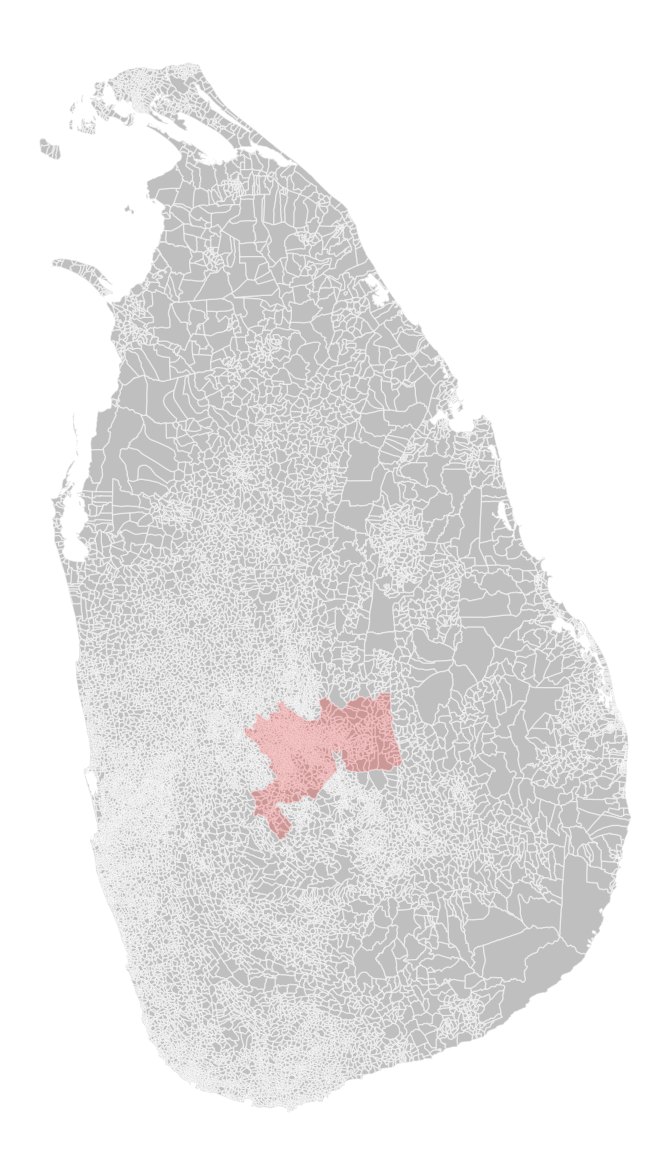

In [115]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

data_shapefile.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

ax.axis('off')

Data obtained from principle component analysis

In [116]:
# calculating the spatial weight (impact from the nearest eight gnds)

wq =  lps.weights.KNN.from_dataframe(gdf,k=8)



In [117]:
y = data_unskewed['pc_1'].values
X = data_unskewed.drop(['pc_1', ], axis=1).values
model_SDEM = GM_Error_Het(y, X, w=wq, name_y='pc_1', name_x=data_unskewed.columns.drop('pc_1').tolist())
print(model_SDEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        pc_1                Number of Observations:        1187
Mean dependent var  :      1.3502                Number of Variables   :          43
S.D. dependent var  :      3.1721                Degrees of Freedom    :        1144
Pseudo R-squared    :      0.5531
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    1424297.9142773             nan             nan             nan
              code_7       0.0000374       0.0000259       1.4472139       0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)


In [118]:
data_unskewed['pred_pc_1'] = model_SDEM.predy.flatten()

Text(0.5, 1.0, 'SDEM model map')

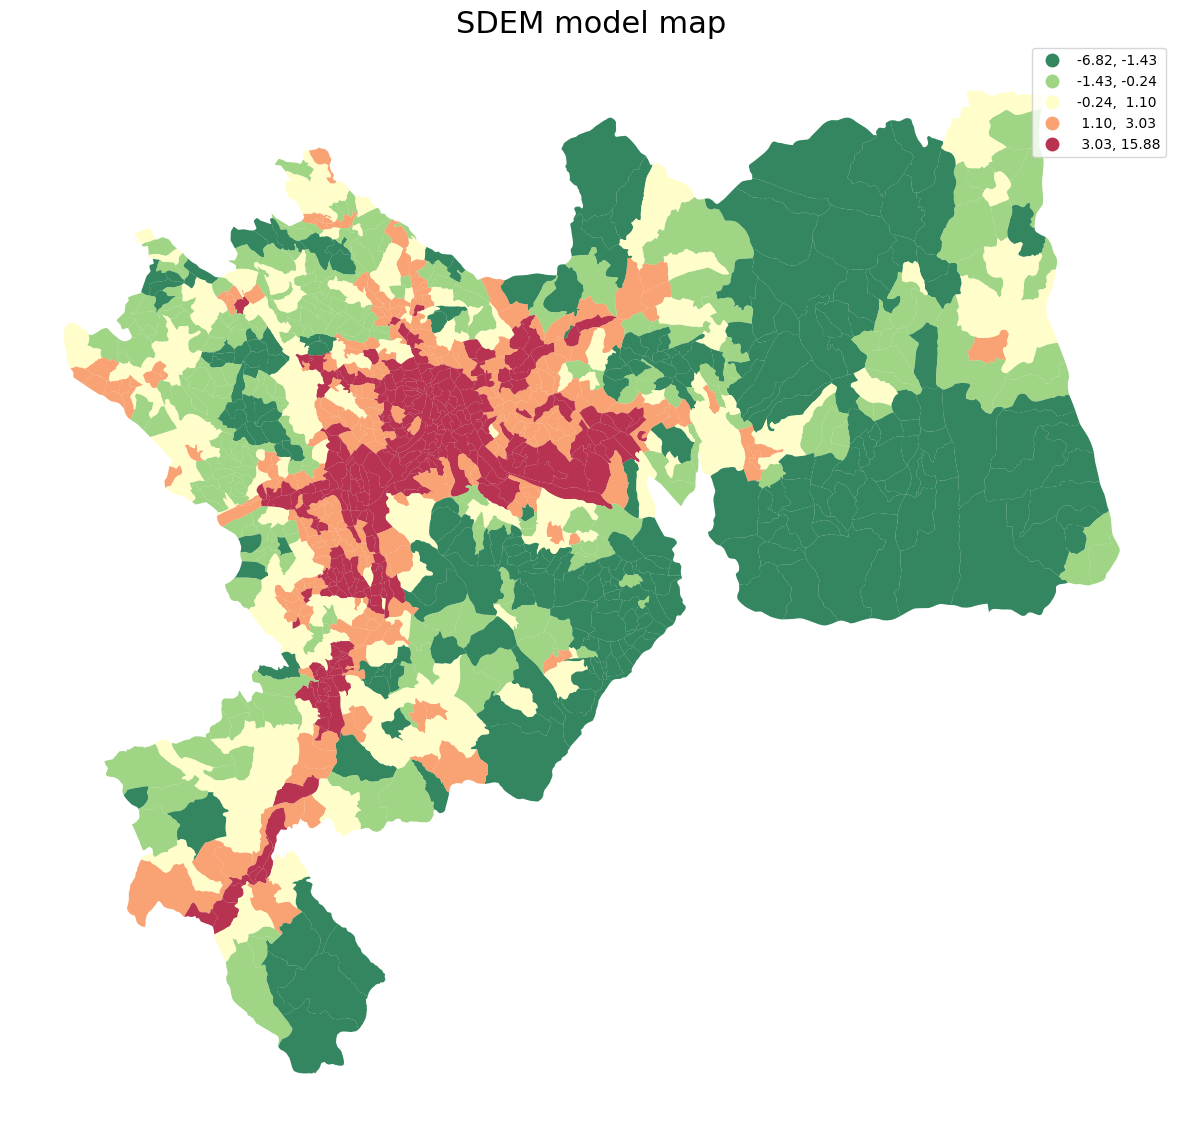

In [119]:
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.code_7, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pred_pc_1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('SDEM model map',fontsize=22)

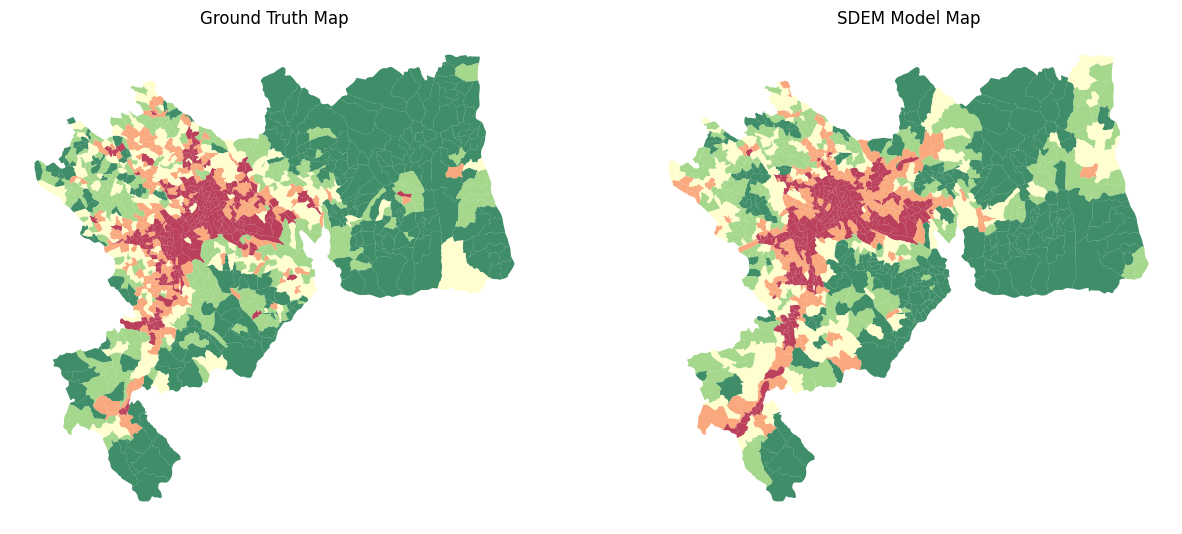

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc_1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")


gdf.plot(ax=ax[1],
         column='pred_pc_1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

In [ ]:
import pytensor.tensor as at
import theano.tensor as T

D0 = int(D / 2)

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    
    # Shrunken coefficients using Theano's tensor operations
    beta = pm.Deterministic(
        "beta", z * tau * lam * T.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + T.dot(T.as_tensor_variable(X.values), beta), sigma, observed=y.values)

Prediction of top 50%